In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a few different labels and study how they affect the generated emebdding space. For now, we focus *povo* and *categoria*.

In [3]:
from PIL import Image

# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open(row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [4]:
import torch
from torchvision import transforms
from training_utils import preparing_image_labels, ImageDataset

# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=transform, augment=False)

In [5]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
from transformers import ViTImageProcessor, ViTModel
from training_utils import get_vit_embeddings, data_projections

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, _ = get_vit_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

Computing embeddings: 100%|█|
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
from training_utils import clean_mem

# Cleaning up memory
clean_mem([model, image_embeddings])

### Fine-tuning Embedding Space

In [7]:
# Creating our own ViT classifier head for fine-tuning
import torch.nn as nn

class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Do I get the last_hidden_state of CLS token or the pooler_output?
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits = self.classifier(embeddings)
        return logits

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
from training_utils import study_class_distribution

categories, categories_keys, categories_freq, qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
filtered_categories = {}
filtered_categories_names = {}
for c in masks[3][0]:
    filtered_categories[categories_keys[c]] = categories[categories_keys[c]]
    filtered_categories_names[num_to_name[categories_keys[c]]] = categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
from training_utils import filter_image_data_distribution

threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            filtered_categories_names, \
                                                            transform, threshold_multiplier, \
                                                            'povo')

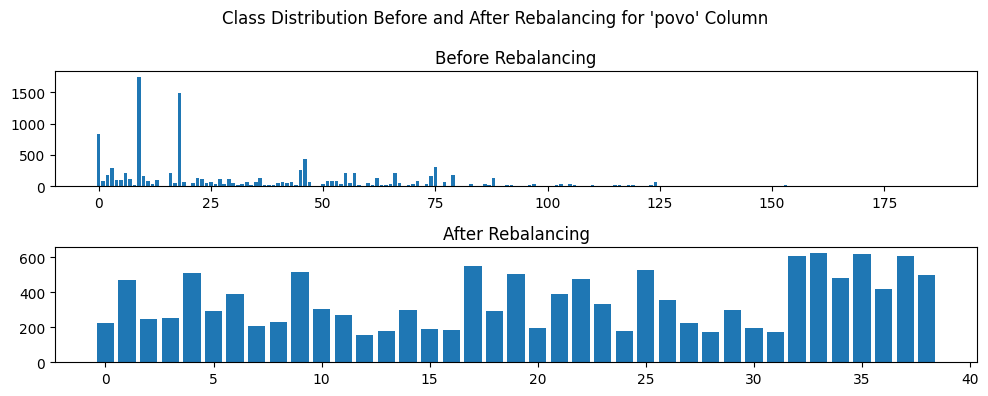

In [10]:
# Plotting old and new class distributions
from training_utils import plot_class_distributions

plot_class_distributions(categories, filtered_categories, labels_minority, labels_majority, \
                         threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
from training_utils import compute_class_weights

povo_class_weights = compute_class_weights(filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   3%| | 1/30 

Best model saved at epoch 1
Epoch 1, Loss: 1047.9526, Validation Accuracy: 0.3795


Training model:   7%| | 2/30 

Best model saved at epoch 2
Epoch 2, Loss: 774.2683, Validation Accuracy: 0.4649


Training model:  10%| | 3/30 

Best model saved at epoch 3
Epoch 3, Loss: 600.8712, Validation Accuracy: 0.5502


Training model:  13%|▏| 4/30 

Best model saved at epoch 4
Epoch 4, Loss: 455.6366, Validation Accuracy: 0.5988


Training model:  17%|▏| 5/30 

Best model saved at epoch 5
Epoch 5, Loss: 331.8320, Validation Accuracy: 0.6198


Training model:  20%|▏| 6/30 

Best model saved at epoch 6
Epoch 6, Loss: 229.7808, Validation Accuracy: 0.6454


Training model:  23%|▏| 7/30 

Best model saved at epoch 7
Epoch 7, Loss: 156.3153, Validation Accuracy: 0.6619


Training model:  27%|▎| 8/30 

Epoch 8, Loss: 100.9891, Validation Accuracy: 0.6605


Training model:  30%|▎| 9/30 

Best model saved at epoch 9
Epoch 9, Loss: 66.6197, Validation Accuracy: 0.6802


Training model:  33%|▎| 10/30

Epoch 10, Loss: 44.4573, Validation Accuracy: 0.6717


Training model:  37%|▎| 11/30

Best model saved at epoch 11
Epoch 11, Loss: 31.2913, Validation Accuracy: 0.6861


Training model:  40%|▍| 12/30

Epoch 12, Loss: 58.2099, Validation Accuracy: 0.6454


Training model:  43%|▍| 13/30

Epoch 13, Loss: 33.5058, Validation Accuracy: 0.6619


Training model:  47%|▍| 14/30

Epoch 14, Loss: 17.4446, Validation Accuracy: 0.6829


Training model:  50%|▌| 15/30

Best model saved at epoch 15
Epoch 15, Loss: 10.3005, Validation Accuracy: 0.6875


Training model:  53%|▌| 16/30

Best model saved at epoch 16
Epoch 16, Loss: 7.4035, Validation Accuracy: 0.6921


Training model:  57%|▌| 17/30

Epoch 17, Loss: 5.7657, Validation Accuracy: 0.6907


Training model:  60%|▌| 18/30

Epoch 18, Loss: 4.8013, Validation Accuracy: 0.6861


Training model:  63%|▋| 19/30

Epoch 19, Loss: 4.0988, Validation Accuracy: 0.6875


Training model:  67%|▋| 20/30

Epoch 20, Loss: 3.3479, Validation Accuracy: 0.6901


Training model:  70%|▋| 21/30

Epoch 21, Loss: 2.7395, Validation Accuracy: 0.6875


Training model:  73%|▋| 22/30

Epoch 22, Loss: 2.3335, Validation Accuracy: 0.6907


Training model:  77%|▊| 23/30

Epoch 23, Loss: 1.9747, Validation Accuracy: 0.6888


Training model:  80%|▊| 24/30

Epoch 24, Loss: 1.7451, Validation Accuracy: 0.6861


Training model:  80%|▊| 24/30


Early-stopping training!


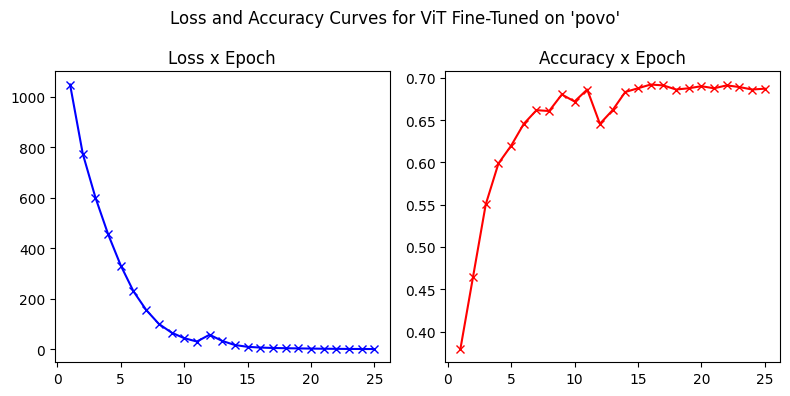

Per class precision: [0.748046875, 0.35302734375, 0.5712890625, 0.7646484375, 0.39990234375, 0.384521484375, 1.0, 0.60009765625, 1.0, 0.8857421875, 0.5, 0.5556640625, 1.0, 0.28125, 0.0, 0.0, 0.79150390625, 0.35302734375, 0.81298828125, 0.35302734375, 1.0, 0.75, 0.9287109375, 0.875, 0.625, 0.199951171875, 0.5712890625, 0.63623046875, 0.5, 0.68408203125, 0.39990234375, 0.0, 0.5, 0.384521484375, 1.0, 0.7001953125, 0.8125, 0.0, 0.0, 0.0, 0.333251953125, 0.25, 0.1875, 0.5, 0.0, 0.66650390625, 0.83056640625, 0.89990234375, 0.0, 0.0, 0.28564453125, 1.0, 0.300048828125, 0.529296875, 0.66650390625, 0.83349609375, 0.71435546875, 0.65380859375, 0.333251953125, 0.0, 0.75, 0.0, 0.5, 1.0, 0.333251953125, 0.0, 0.5712890625, 0.5, 0.0, 0.5, 0.0, 0.5712890625, 0.0, 0.75, 0.60888671875, 0.744140625, 0.0, 0.53857421875, 0.0, 0.44189453125, 0.0, 1.0, 0.0, 1.0, 0.0, 0.333251953125, 0.0, 1.0, 0.54541015625, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.333251953125, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/training_utils.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/mode

Test accuracy: 0.6725820899009705

Test per class precisions: [0.7471264600753784, 0.5714285969734192, 0.2777777910232544, 0.6000000238418579, 0.75, 0.3529411852359772, 1.0, 0.6363636255264282, 1.0, 0.918749988079071, 0.25, 1.0, 0.5, 0.15789473056793213, 0.0, 0.0, 0.8421052694320679, 0.5, 0.7261146306991577, 0.375, 0.0, 0.8571428656578064, 0.7222222089767456, 0.9333333373069763, 1.0, 0.25, 1.0, 0.9166666865348816, 0.0, 0.8571428656578064, 0.5, 1.0, 0.0, 0.4285714328289032, 0.0, 0.875, 0.7142857313156128, 0.0, 1.0, 0.0, 0.5, 0.6000000238418579, 0.25, 0.3333333432674408, 0.0, 0.7428571581840515, 0.7179487347602844, 0.5, 0.0, 0.0, 0.5, 1.0, 0.2857142984867096, 0.09090909361839294, 0.0, 0.6842105388641357, 0.5714285969734192, 0.7727272510528564, 0.5, 0.0, 0.6666666865348816, 0.0, 0.1764705926179886, 0.6666666865348816, 0.0, 0.5, 0.4399999976158142, 0.4285714328289032, 0.0, 1.0, 0.0, 0.6666666865348816, 0.0, 1.0, 0.75, 0.7407407164573669, 0.0, 0.800000011920929, 0.0, 0.38461539149284363, 0.

In [12]:
# import training_utils
# importlib.reload(training_utils)
import random
from training_utils import execute_train_test
import torch.nn as nn
import torch.optim as optim

# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['povo'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

execute_train_test(povo_train_val_dataset, povo_test_dataset, device, batch_size, epochs, \
                   num_classes, model, criterion, opt, model_name, column_name)

In [13]:
# Cleaning up memory
clean_mem([model])

Training model:   3%| | 1/30 

Best model saved at epoch 1
Epoch 1, Loss: 1219.2093, Validation Accuracy: 0.5696


Training model:   7%| | 2/30 

Best model saved at epoch 2
Epoch 2, Loss: 566.2030, Validation Accuracy: 0.6995


Training model:  10%| | 3/30 

Epoch 3, Loss: 146.2630, Validation Accuracy: 0.6995


Training model:  13%|▏| 4/30 

Best model saved at epoch 4
Epoch 4, Loss: 43.6966, Validation Accuracy: 0.7042


Training model:  17%|▏| 5/30 

Best model saved at epoch 5
Epoch 5, Loss: 26.9947, Validation Accuracy: 0.7074


Training model:  20%|▏| 6/30 

Epoch 6, Loss: 21.5162, Validation Accuracy: 0.6870


Training model:  23%|▏| 7/30 

Epoch 7, Loss: 23.6888, Validation Accuracy: 0.6667


Training model:  23%|▏| 7/30 


Early-stopping training!


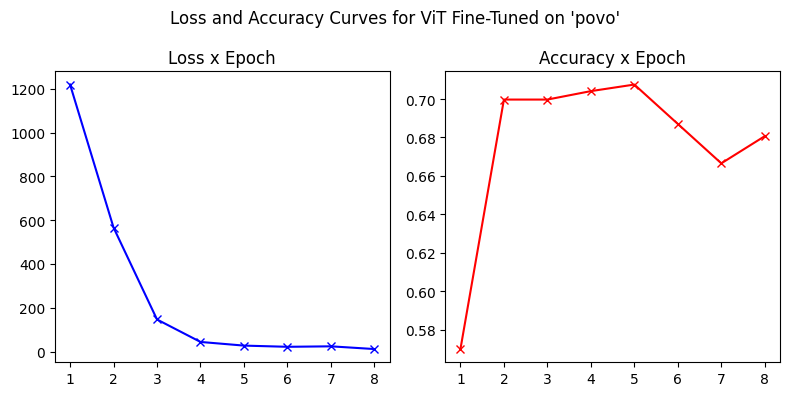

Per class precision: [0.25, 0.60009765625, 0.25, 0.7998046875, 1.0, 0.71435546875, 0.5263671875, 1.0, 0.5, 0.70849609375, 1.0, 1.0, 0.625, 0.89990234375, 0.75, 0.83349609375, 0.272705078125, 0.66650390625, 0.4443359375, 0.75, 0.83349609375, 0.64697265625, 0.294189453125, 0.416748046875, 0.625, 0.85009765625, 0.43994140625, 0.7998046875, 0.5, 0.58349609375, 1.0, 1.0, 0.77294921875, 0.7568359375, 0.77783203125, 0.69775390625, 0.5654296875, 0.7177734375, 0.615234375]

Per class recall: [0.199951171875, 0.272705078125, 0.333251953125, 0.5712890625, 0.86376953125, 0.625, 0.5263671875, 0.83349609375, 0.25, 0.85009765625, 0.875, 0.58349609375, 0.5, 0.818359375, 0.64306640625, 0.416748046875, 0.300048828125, 0.63623046875, 0.25, 0.60009765625, 0.66650390625, 0.5791015625, 0.416748046875, 1.0, 1.0, 0.85009765625, 0.84619140625, 0.5712890625, 0.28564453125, 0.63623046875, 1.0, 1.0, 0.85009765625, 0.7568359375, 0.75, 0.78955078125, 0.8125, 0.7568359375, 0.64013671875]

Test accuracy: 0.7299651503

Computing embeddings: 100%|█|
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
from training_utils import compute_classifier_embeddings

# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 30
num_classes = len(filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

In [15]:
# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [16]:
# Now rebalancing the 'categoria' column
categoria_labels, name_to_num, num_to_name = preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [name_to_num['etnobotânica']]
filtered_categories = {}
filtered_categories_names = {}
for c in set(name_to_num.values()) - set(filter_out):
    filtered_categories[categories_keys[c]] = categories[categories_keys[c]]
    filtered_categories_names[num_to_name[categories_keys[c]]] = categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [17]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                                 filtered_categories_names, \
                                                                 transform, \
                                                                 threshold_multiplier, \
                                                                 'categoria')

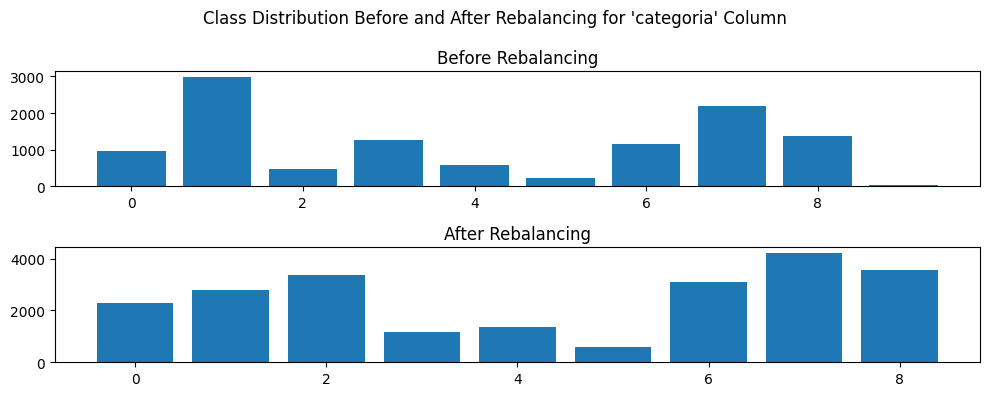

In [18]:
# Plotting old and new class distributions
from training_utils import plot_class_distributions

plot_class_distributions(categories, filtered_categories, labels_minority, labels_majority, \
                         threshold_multiplier, 'categoria')

In [19]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
from training_utils import compute_class_weights

categoria_class_weights = compute_class_weights(filtered_categories, labels_minority, \
                                                labels_majority, device, threshold_multiplier)

Training model:   3%| | 1/30 

Best model saved at epoch 1
Epoch 1, Loss: 384.7775, Validation Accuracy: 0.7334


Training model:   7%| | 2/30 

Best model saved at epoch 2
Epoch 2, Loss: 197.9300, Validation Accuracy: 0.8313


Training model:  10%| | 3/30 

Best model saved at epoch 3
Epoch 3, Loss: 117.8947, Validation Accuracy: 0.8654


Training model:  13%|▏| 4/30 

Epoch 4, Loss: 71.0193, Validation Accuracy: 0.8391


Training model:  17%|▏| 5/30 

Epoch 5, Loss: 46.6933, Validation Accuracy: 0.8457


Training model:  20%|▏| 6/30 

Epoch 6, Loss: 30.6630, Validation Accuracy: 0.8654


Training model:  23%|▏| 7/30 

Best model saved at epoch 7
Epoch 7, Loss: 21.0813, Validation Accuracy: 0.8844


Training model:  27%|▎| 8/30 

Epoch 8, Loss: 17.3150, Validation Accuracy: 0.8752


Training model:  30%|▎| 9/30 

Epoch 9, Loss: 17.5371, Validation Accuracy: 0.8667


Training model:  33%|▎| 10/30

Epoch 10, Loss: 12.9935, Validation Accuracy: 0.8805


Training model:  37%|▎| 11/30

Epoch 11, Loss: 8.5637, Validation Accuracy: 0.8812


Training model:  40%|▍| 12/30

Best model saved at epoch 12
Epoch 12, Loss: 7.4981, Validation Accuracy: 0.8851


Training model:  43%|▍| 13/30

Epoch 13, Loss: 5.0076, Validation Accuracy: 0.8825


Training model:  47%|▍| 14/30

Epoch 14, Loss: 3.9672, Validation Accuracy: 0.8851


Training model:  50%|▌| 15/30

Epoch 15, Loss: 14.5909, Validation Accuracy: 0.8529


Training model:  53%|▌| 16/30

Epoch 16, Loss: 8.5858, Validation Accuracy: 0.8713


Training model:  53%|▌| 16/30

Early-stopping training!


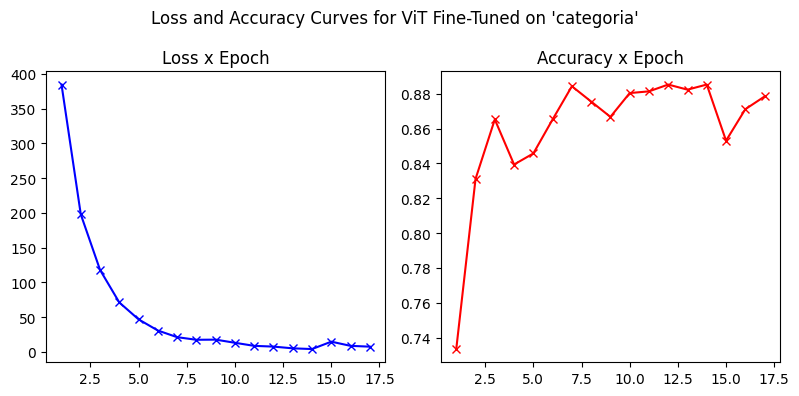

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/training_utils.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/mode

Per class precision: [0.888671875, 0.89501953125, 0.625, 0.91943359375, 0.90576171875, 0.888671875, 0.8759765625, 0.96044921875, 0.74609375, 0.0]

Per class recall: [0.8291015625, 0.916015625, 0.76904296875, 0.83154296875, 0.927734375, 0.685546875, 0.85791015625, 0.97021484375, 0.8046875, 0.0]

Test accuracy: 0.8819875717163086

Test per class precisions: [0.75, 0.9220339059829712, 0.9285714030265808, 0.8909090757369995, 0.9166666865348816, 0.75, 0.9075630307197571, 0.9663461446762085, 0.7388535141944885, 1.0]

Test per class recalls: [0.8888888955116272, 0.885993480682373, 0.8387096524238586, 0.859649121761322, 0.8461538553237915, 0.7200000286102295, 0.9230769276618958, 0.9571428298950195, 0.8226950168609619, 0.4000000059604645]



In [20]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 30
num_classes = ind_df['categoria'].nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_train_val_dataset, categoria_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name)

In [21]:
# Cleaning up memory
clean_mem([model])

Training model:   3%| | 1/30 

Best model saved at epoch 1
Epoch 1, Loss: 1210.7775, Validation Accuracy: 0.8335


Training model:   7%| | 2/30 

Best model saved at epoch 2
Epoch 2, Loss: 310.2724, Validation Accuracy: 0.8666


Training model:  10%| | 3/30 

Best model saved at epoch 3
Epoch 3, Loss: 122.7229, Validation Accuracy: 0.8896


Training model:  13%|▏| 4/30 

Epoch 4, Loss: 70.1322, Validation Accuracy: 0.8740


Training model:  17%|▏| 5/30 

Epoch 5, Loss: 64.8170, Validation Accuracy: 0.8740


Training model:  20%|▏| 6/30 

Best model saved at epoch 6
Epoch 6, Loss: 35.7752, Validation Accuracy: 0.8942


Training model:  23%|▏| 7/30 

Epoch 7, Loss: 32.8695, Validation Accuracy: 0.8822


Training model:  27%|▎| 8/30 

Epoch 8, Loss: 36.0262, Validation Accuracy: 0.8813


Training model:  27%|▎| 8/30 


Early-stopping training!


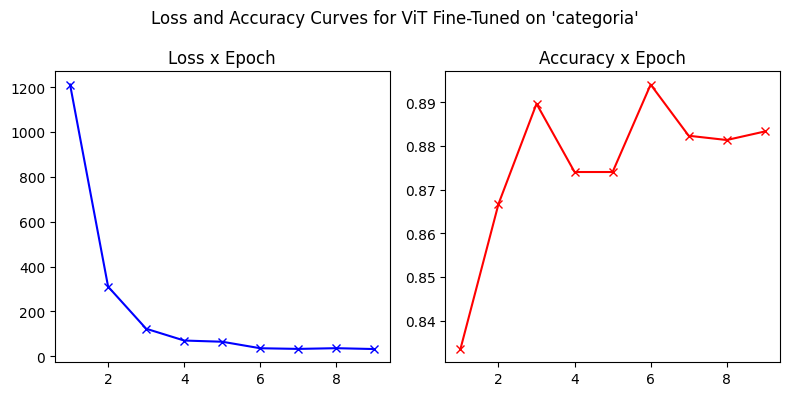

Per class precision: [0.837890625, 0.85498046875, 0.73681640625, 0.85009765625, 0.947265625, 1.0, 0.8779296875, 0.90185546875, 0.97607421875]

Per class recall: [0.87109375, 0.9365234375, 0.80322265625, 0.7236328125, 0.84375, 0.76171875, 0.86376953125, 0.8984375, 0.95361328125]

Test accuracy: 0.9028629660606384

Test per class precisions: [0.9135802388191223, 0.9115044474601746, 0.7983871102333069, 0.8974359035491943, 0.9090909361839294, 0.9444444179534912, 0.8067227005958557, 0.9246861934661865, 0.994413435459137]

Test per class recalls: [0.8705882430076599, 0.9537037014961243, 0.8181818127632141, 0.8333333134651184, 0.9230769276618958, 0.8947368264198303, 0.9142857193946838, 0.9094650149345398, 0.9368420839309692]



Computing embeddings: 100%|█|
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [22]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 30
num_classes = len(filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

In [23]:
# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [24]:
from training_utils import normalize

# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

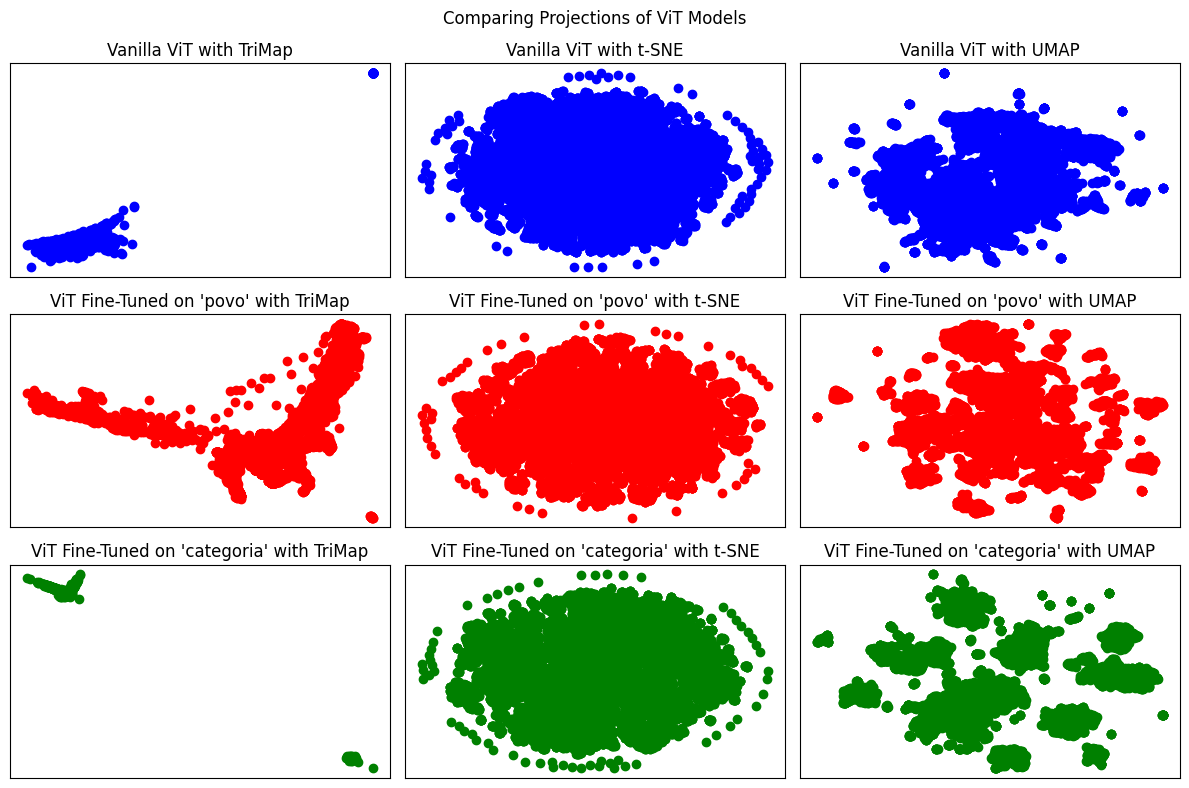

In [25]:
import matplotlib.pyplot as plt

# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
for i, (vanilla_vit, proj_name) in enumerate(zip([vanilla_vit_trimap, \
                                                  vanilla_vit_tsne, vanilla_vit_umap], \
                                                 ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+1)
    plt.scatter(vanilla_vit[:, 0], vanilla_vit[:, 1], c='b')
    plt.title("Vanilla ViT with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'povo' projections
for i, (povo_vit, proj_name) in enumerate(zip([povo_vit_trimap, \
                                               povo_vit_tsne, povo_vit_umap], \
                                              ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+4)
    plt.scatter(povo_vit[:, 0], povo_vit[:, 1], c='r')
    plt.title("ViT Fine-Tuned on 'povo' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

# Plotting ViT fine-tuned on 'categoria' projections
for i, (categoria_vit, proj_name) in enumerate(zip([categoria_vit_trimap, \
                                                    categoria_vit_tsne, categoria_vit_umap], \
                                                   ['TriMap', 't-SNE', 'UMAP'])):
    plt.subplot(3, 3, i+7)
    plt.scatter(categoria_vit[:, 0], categoria_vit[:, 1], c='g')
    plt.title("ViT Fine-Tuned on 'categoria' with " + proj_name)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

### Visualizing Clusters

/home/lui/Documents/uva/thesis/indigenous_project/tainacan_collection/training_utils.py:470: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


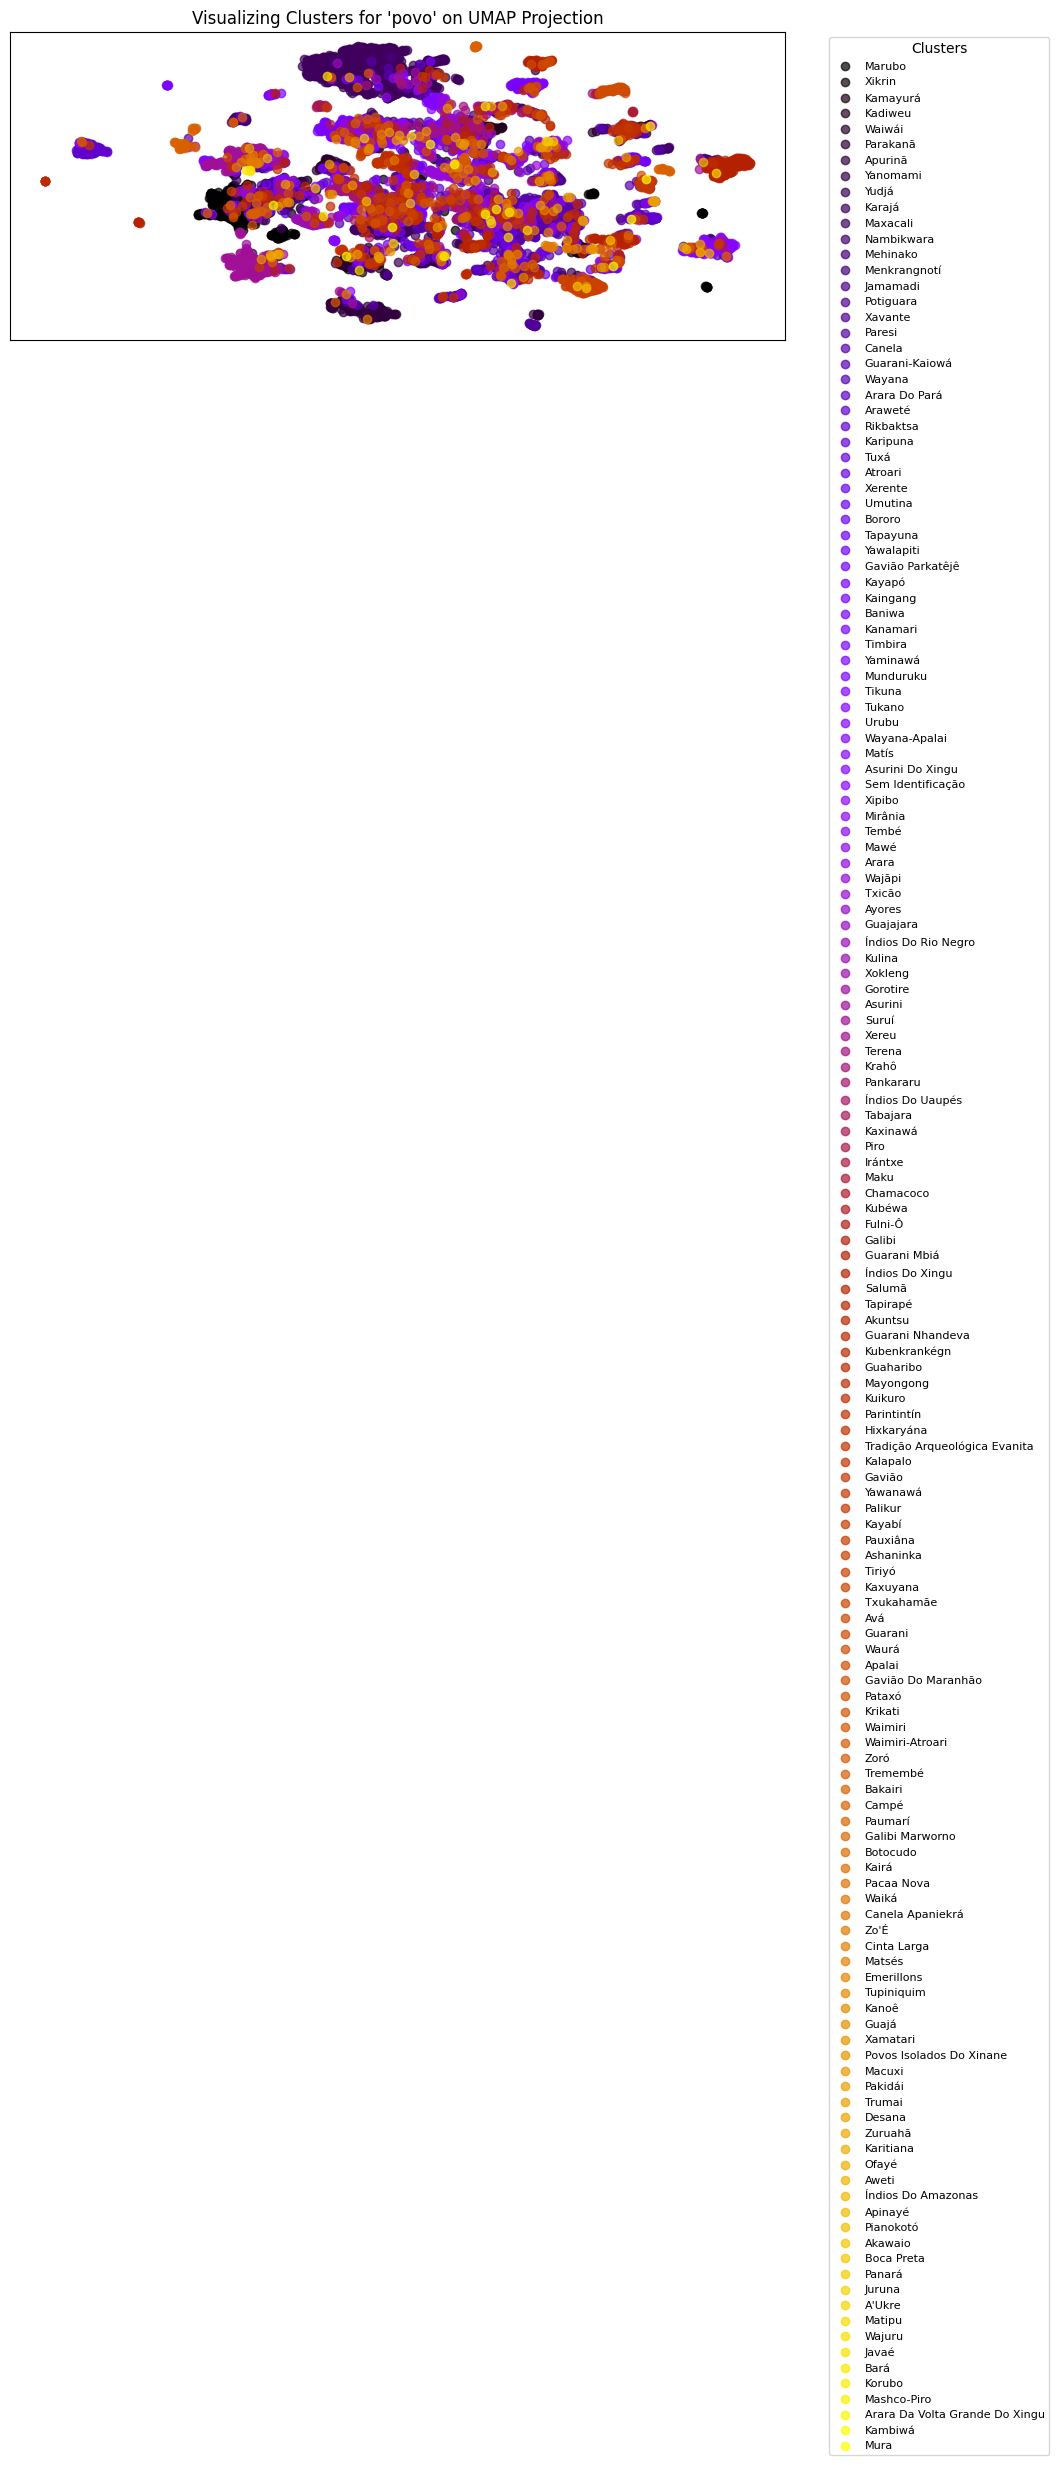

In [26]:
# import training_utils
# importlib.reload(training_utils)
from training_utils import visualizing_clusters

# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

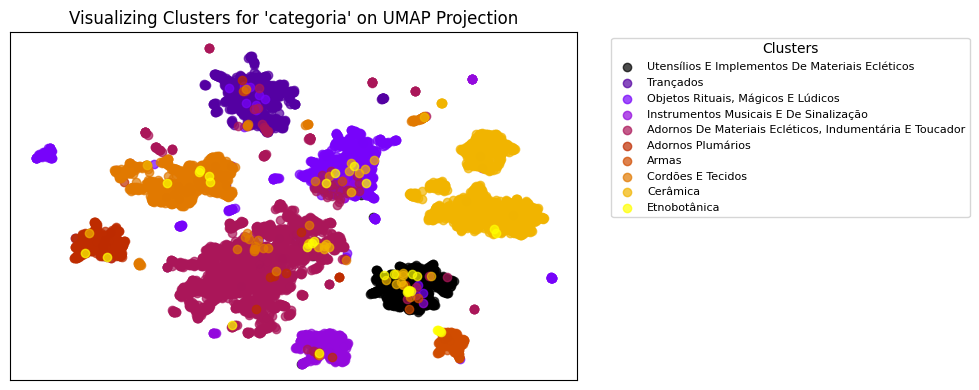

In [27]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

In [28]:
# Saving outputs for visualization tool
from training_utils import saving_outputs

_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

,x,y,cluster,cluster_names
id,,,,
55663,3.073530,-5.527454,0,utensílios e implementos de materiais ecléticos
55668,4.884960,-4.046072,0,utensílios e implementos de materiais ecléticos
55673,3.693570,-3.134145,0,utensílios e implementos de materiais ecléticos
55678,7.025996,-0.503627,0,utensílios e implementos de materiais ecléticos
55688,4.701532,-3.679965,0,utensílios e implementos de materiais ecléticos
...,...,...,...,...
41613,2.328540,-4.351409,0,utensílios e implementos de materiais ecléticos
41618,-1.765116,1.179422,4,"adornos de materiais ecléticos, indumentária e..."
41628,-4.301723,10.149202,1,trançados
